In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from collections import defaultdict
from typing import Dict

## Block 1

In [4]:
py_filepath = "/ho0me/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"

#### Load file

In [5]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

In [6]:
# Selec trials in a block
n_block = 1
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
b_sp_samples = [sp_py['sp_samples'][i] for i in trial_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))

Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of clusters: 16


In [7]:
# sample identity
# IN:
# A: (1o 1c) 1 - 7
# B: (1o 5c) 8 - 14
# C: (5o 1c) 15 - 21
# D: (5o 5c) 22 - 28 

In [8]:
condition = np.arange(1,57)
samples_cond = {
    # samples IN
    'a_in' : np.arange(1,8),
    'b_in' : np.arange(8,15),
    'c_in' : np.arange(15,22),
    'd_in' : np.arange(22,29),
}

In [9]:
def test_stim(task,bhv_idx):
    for key,value in bhv_idx.items():
        if 'Stim_Filename_' in key:
            val = value.item(0).decode('utf-8')
            if key[-1] == 'd': # distractor
                task['test_stimuli_'+key[-2:]] += [val[-11:-4]]
            else:
                task['test_stimuli_'+key[-1]] += [val[-11:-4]]
                n_test =  int(key[-1])

    for n in range(n_test+1,6):
        task['test_stimuli_'+str(n)] += ['']
        task['test_stimuli_'+str(n)+'d'] += ['']

    return task,n_test

In [10]:
samples_cond['a_in']+28

array([29, 30, 31, 32, 33, 34, 35])

In [11]:
def create_task_frame(trial_idx,bhv,samples_cond):
    task:Dict[str,list] = defaultdict(list)#{}
    for idx in trial_idx:
        task['idx_trial'] += [idx]
        cond = int(bhv[idx]['Condition'][0][0])
        a_out = samples_cond['a_in']+28
        b_out = samples_cond['b_in']+28
        c_out = samples_cond['c_in']+28
        d_out = samples_cond['d_in']+28
        # IN
        if cond in samples_cond['a_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['A']
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['a_in'][-1]-cond)]
        elif cond in samples_cond['b_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['B']
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['b_in'][-1]-cond)]
        elif cond in samples_cond['c_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['C']
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['c_in'][-1]-cond)]
        elif cond in samples_cond['d_in']:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['D']
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (samples_cond['d_in'][-1]-cond)]
        # OUT
        elif cond in a_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['A']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (a_out[-1]-cond)]
        elif cond in b_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['B']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (b_out[-1]-cond)]
        elif cond in c_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['C']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (c_out[-1]-cond)]
        elif cond in d_out:
            task,n_test = test_stim(task,bhv[idx])
            task['sample_id'] += ['D']
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [7- (d_out[-1]-cond)]

    return pd.DataFrame(task)

In [12]:
task=create_task_frame(trial_idx,bhv,samples_cond)

In [13]:
sample_on = 23
test_on_1=25 
# kernel parameters
fs = 30000
w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms

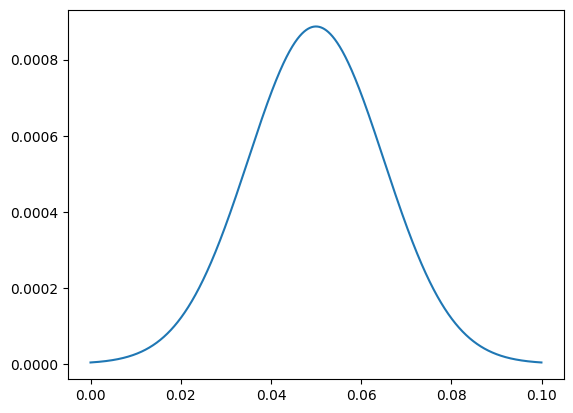

In [14]:
# define kernel for the convolution
kernel = signal.gaussian(M=w_size*fs,std=w*fs)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs,kernel)

In [15]:
def get_neuron_in_trials(sp_py,neuron,sample_on,test_on_1,trials_idx): # check how to adapt the one from firing_rate
    # create list of neurons containing trials 
    trials = sp_py["sp_samples"][trials_idx]  # select trials
    neuron_trials = []
    for i_t, n_trial in zip(trials_idx, trials):
        idx_sample_on = np.where(sp_py["code_numbers"][i_t] == sample_on)[0]
        idx_test_on_1 = np.where(sp_py["code_numbers"][i_t] == test_on_1)[0]
        
        sample_sample_on = sp_py["code_samples"][i_t][idx_sample_on]
        sample_test_on_1 = sp_py["code_samples"][i_t][idx_test_on_1]-sample_sample_on

        neuron_trials.append(n_trial[neuron] - sample_sample_on)
    return neuron_trials,sample_test_on_1


/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


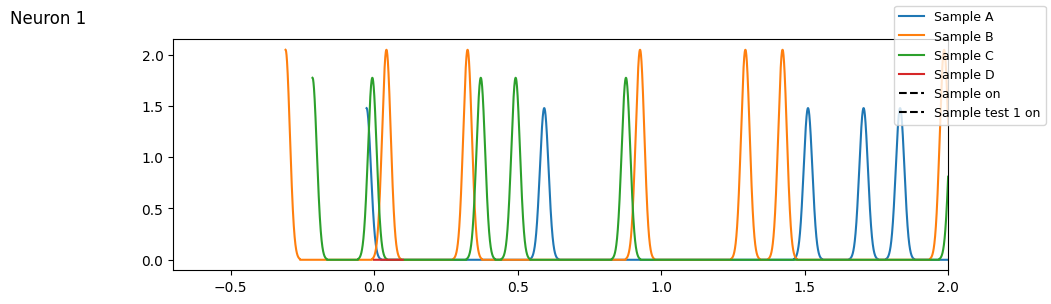

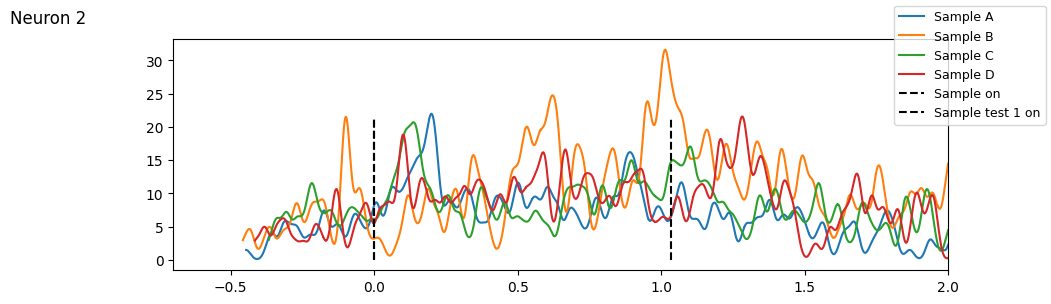

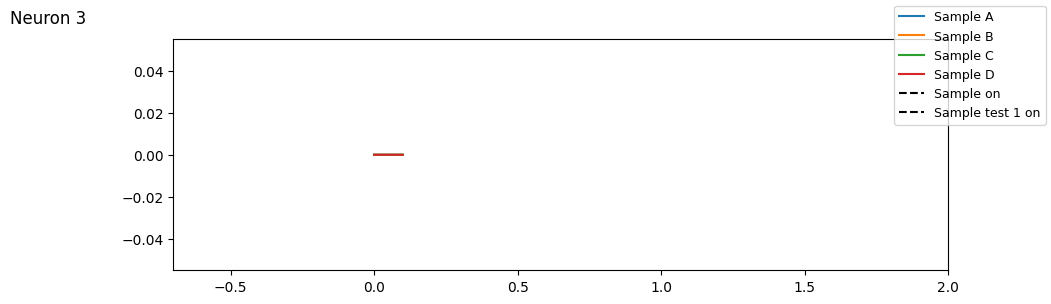

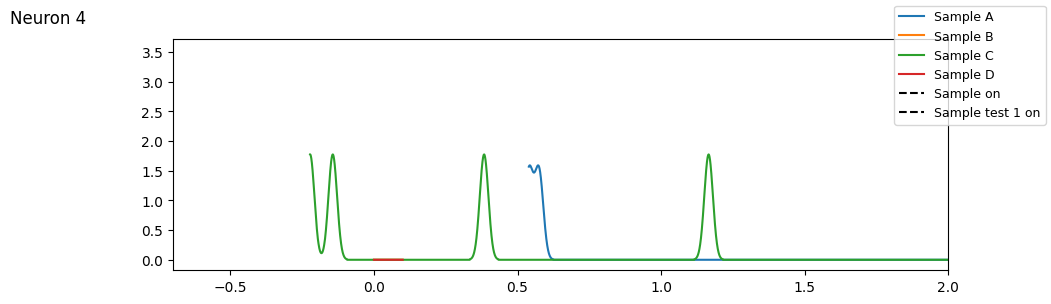

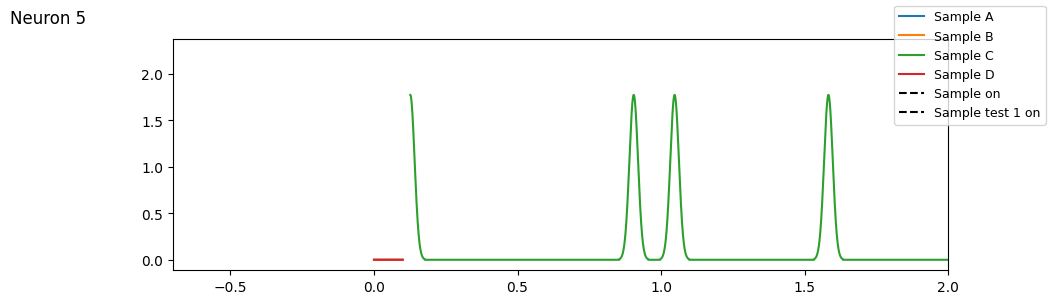

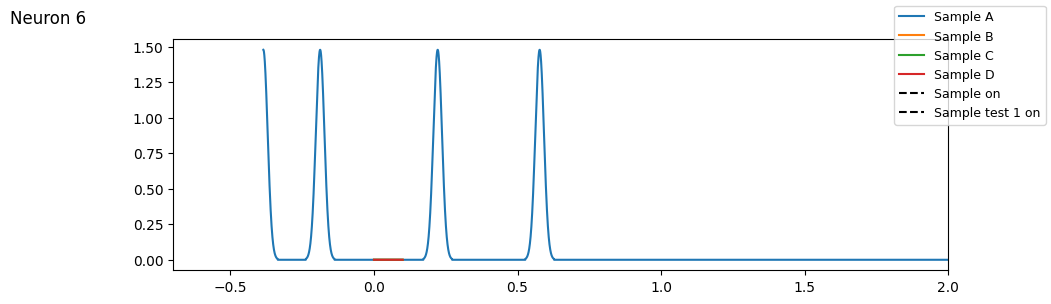

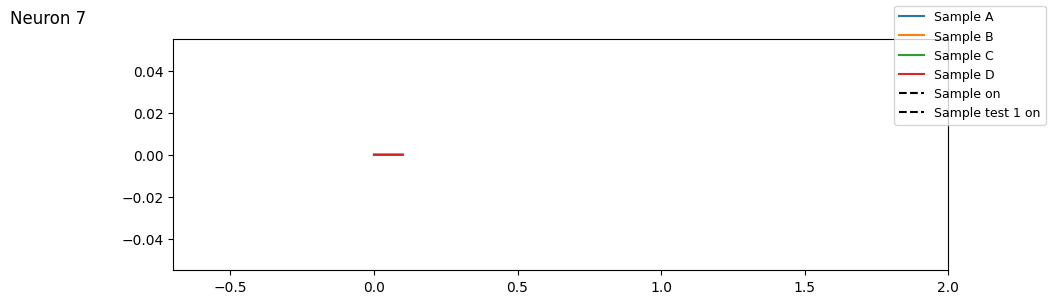

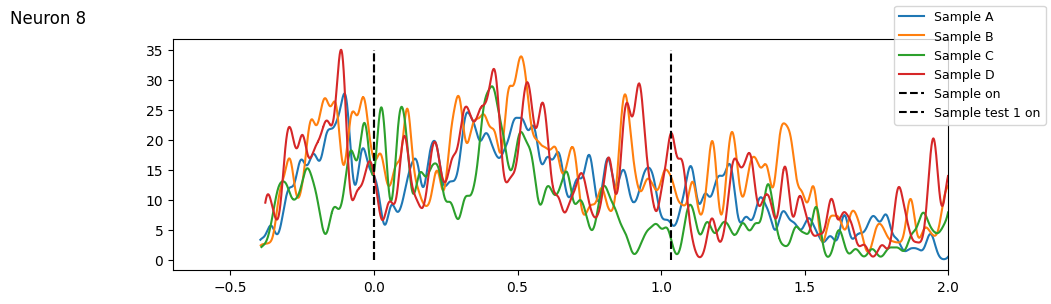

In [16]:
fs = 30000
x_lim_max=2
x_lim_min = -0.7
neurons = np.where(sp_py['clustersgroup']=='good')[0]

for i,neuron in enumerate(neurons):
    fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
    for sample in ['A','B','C','D']:
        trials_idx = task[(task['sample_id']==sample) & (task['in_out']==1) & (task['in_out']==1) & (task['n_test_stimuli']==1)]['idx_trial'].values
        neuron_trials,sample_test_on_1 = get_neuron_in_trials(sp_py,neuron,sample_on,test_on_1 ,trials_idx) 
        if len(neuron_trials[0]) != 0:
            # Compute trial average fr
            trial_average_sp,sorted_sp_neuron = firing_rate.trial_average_fr(neuron_trials)
        else:
            trial_average_sp=[0]*len(kernel)
            sorted_sp_neuron=[0]*len(kernel)
        conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
        # plot
        ax.plot((np.arange(len(trial_average_sp)) + sorted_sp_neuron[0]) / fs, conv)
    ax.vlines(0, 0, max(conv) ,color="k", linestyles="dashed")
    ax.vlines([0,sample_test_on_1/fs], 0, max(conv) ,color="k", linestyles="dashed")
    ax.set_xlim(x_lim_min, x_lim_max)
    fig.legend(['Sample A','Sample B','Sample C','Sample D','Sample on','Sample test 1 on'], fontsize=9)
    fig.suptitle("Neuron %d" % (i + 1), x=0)
    plt.show()

#### split in stimulus presentation delay 